In [9]:
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)


from yadlt.model import load_trained_model, generate_pdf_model
from yadlt.evolution import EvolutionOperatorComputer
from yadlt.distribution import Distribution
from yadlt.context import FitContext

In [10]:
import logging
from yadlt.log import setup_logger

# Set up the root logger to capture all logs in jupyter notebook
logger = setup_logger()

# If you want to see all messages, including DEBUG:
logger.setLevel(logging.INFO)

In [11]:
fitname = "250604-ac-01-L0"

In [12]:
SAVE_NB = False
PLOT_ERROR_BARS = True

In [13]:
# Load context
context = FitContext(fitname, force_serialize=False)

In [14]:
# Load Tommaso's file
fk_grid = context.load_fk_grid()
FK = context.load_fk_table()
f_bcdms = context.load_f_bcdms()
Cy = context.load_bcdms_cov()
Cinv = np.linalg.inv(Cy)
model_input = fk_grid.reshape(1, -1, 1)

nreplicas = context.get_property("nreplicas")

# Compute M
M = FK.T @ Cinv @ FK

In [15]:
learning_rate = float(context.get_config("metadata", "arguments")["learning_rate"])
common_epochs = context.get_config("replicas", "common_epochs")
replicas_folders = context.get_config("folders", "replicas_folders")
epoch_step_size = 500

architecture = context.get_config("metadata", "model_info")['architecture']
activation = context.get_config("metadata", "model_info")["activations"]
kernel_initializer = context.get_config("metadata", "model_info")["kernel_initializer"]
use_scaled_input = context.get_config("metadata", "model_info").get("use_scaled_input", False)
use_preprocessing = context.get_config("metadata", "model_info").get("use_preprocessing", False)

In [16]:
# Extract the last common epoch from the ensemble of replicas
xT3_training = Distribution('xT3_training')
print(f'Loading {len(replicas_folders)} replicas...', end='\t')

for replica_path in replicas_folders:
  model, _ = load_trained_model(replica_path, epoch=-1)
  preds = model(model_input).numpy().squeeze()
  xT3_training.add(preds)
print('Done!')

# Compute T3 from xT3
T3_training = xT3_training.apply_operator(b=fk_grid, operator=lambda a, b: np.true_divide(a, b), axis=0, name=f'T3 at the end of the training')

Loading 100 replicas...	Done!


In [17]:
# Load the data used to fit the replicas
data_by_replica_original = Distribution("Original replicas of the data")

for rep in range(context.get_property("nreplicas")):
  data = context.get_data_by_replica(rep)
  data_by_replica_original.add(data)

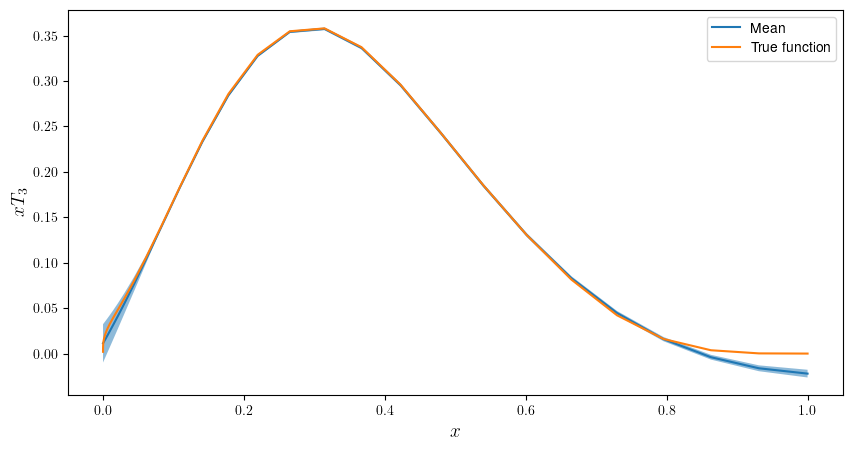

In [18]:
# Plot the ensemble of xT3 at the end of the training
plt.figure(figsize=(10, 5))
plt.plot(fk_grid, xT3_training.get_mean(), label='Mean')
plt.fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), alpha=0.5)
plt.plot(fk_grid, f_bcdms, label='True function')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$xT_3$', fontsize=14)
plt.legend()
plt.show()

In [19]:
from yadlt.utils import gibbs_fn

sigma = 0.6
l0 = 5.0
delta = 1.e-5

# Create the Gibbs kernel matrix
gibbs_kernel = np.fromfunction(
  lambda i, j: gibbs_fn(fk_grid[i], fk_grid[j], delta, sigma, l0),
  (fk_grid.size, fk_grid.size),
  dtype=int
)

gp_kernel_inv = np.linalg.inv(gibbs_kernel)

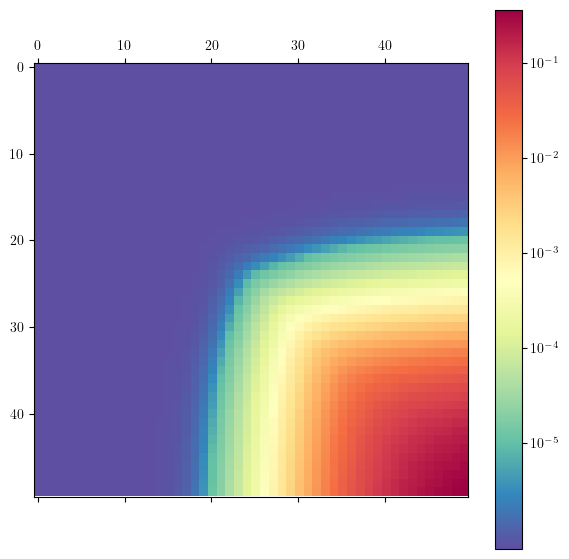

In [20]:
fig, axs = plt.subplots(figsize=(7, 7))
from matplotlib import cm
from matplotlib import colors as mcolors

matrixplot = axs.matshow(
    gibbs_kernel,
    cmap=cm.Spectral_r,
    norm=mcolors.SymLogNorm(
        linthresh=0.00001, linscale=1, vmin=gibbs_kernel.min(), vmax=gibbs_kernel.max()
    ),
)
cbar = fig.colorbar(matrixplot)

# Norm of the NTK over time

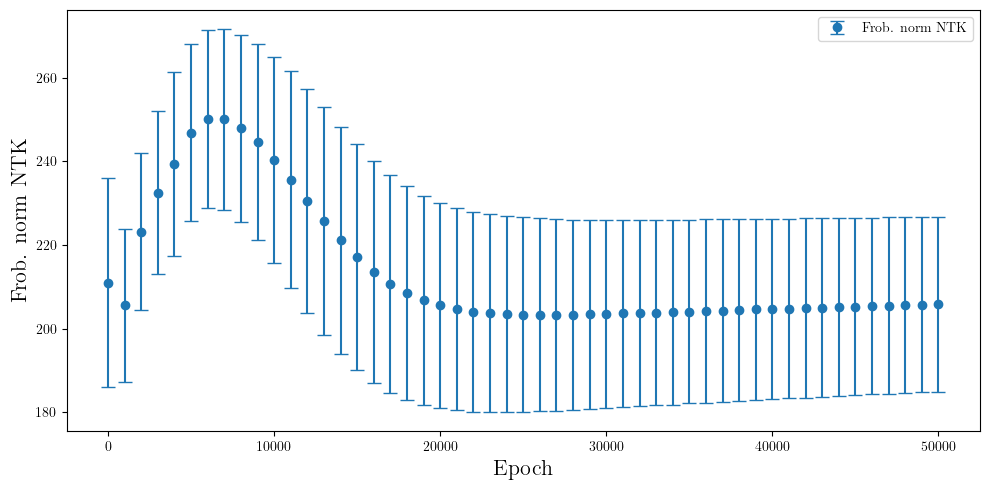

In [21]:
frob_norm_time = context.frob_norm_time
frob_means = np.array([frob.get_mean().squeeze() for frob in frob_norm_time])
frob_stds = np.array([frob.get_std().squeeze() for frob in frob_norm_time])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

if PLOT_ERROR_BARS:
  ax.errorbar(common_epochs, frob_means, yerr=frob_stds, label=r'$\textrm{Frob. norm NTK}$', fmt='o', capsize=5)
else:
  ax.plot(common_epochs, frob_means, label=r'$\textrm{Frob. norm NTK}$')
  ax.fill_between(common_epochs, frob_means - frob_stds, frob_means + frob_stds, alpha=0.5)
  
ax.set_xlabel(r'${\rm Epoch}$', fontsize=16)
ax.set_ylabel(r'$\textrm{Frob. norm NTK}$', fontsize=16)
ax.legend()

fig.tight_layout()

# Change in the NTK over time

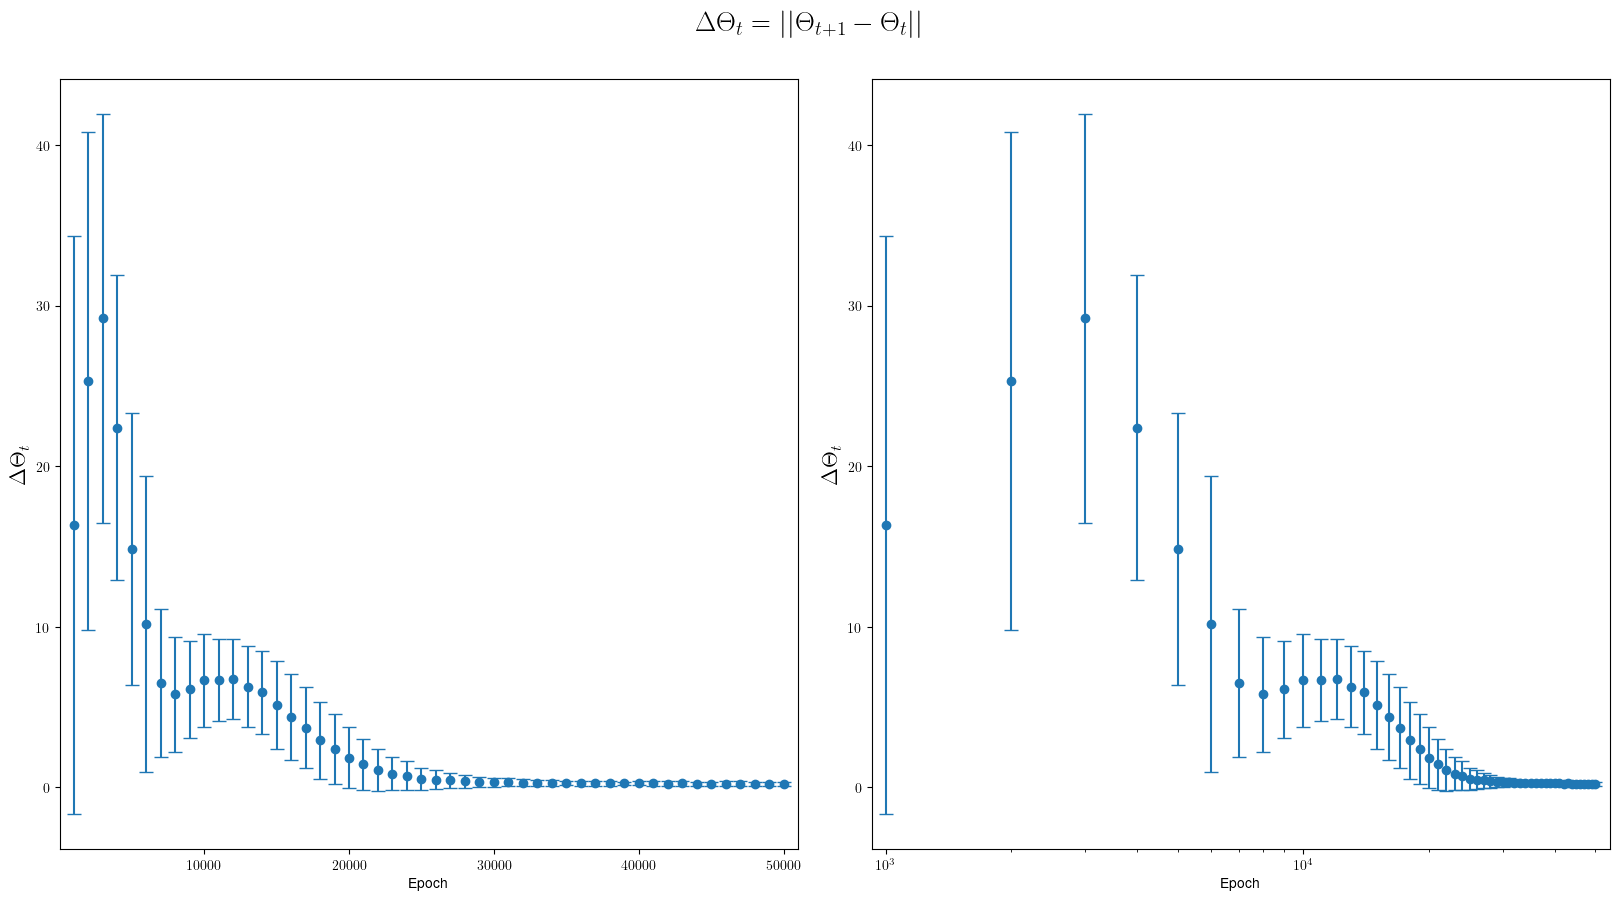

In [22]:
NTK_time = context.NTK_time

# Compute  \Delta\Theta_t = || \Theta_{t+1} - \Theta_t}||
Delta_ntk_t = []
for i in range(len(NTK_time) - 1):
  delta_ntk_dist = Distribution(f'Delta NTK {i}')
  for rep in range(nreplicas):
    delta_ntk = np.linalg.norm(NTK_time[i + 1][rep] - NTK_time[i][rep])
    delta_ntk_dist.add(delta_ntk)
  Delta_ntk_t.append(delta_ntk_dist)

delta_ntk_means = np.array([delta.get_mean() for delta in Delta_ntk_t])
delta_ntk_stds = np.array([delta.get_std() for delta in Delta_ntk_t])

fig, axs = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

if PLOT_ERROR_BARS:
  axs[0].errorbar(common_epochs[1:], delta_ntk_means, yerr=delta_ntk_stds, label=r'$\Delta \Theta_t$', fmt='o', capsize=5)
  axs[1].errorbar(common_epochs[1:], delta_ntk_means, yerr=delta_ntk_stds, label=r'$\Delta \Theta_t$', fmt='o', capsize=5)
else:
  axs[0].plot(common_epochs[1:], delta_ntk_means, label=r'$\Delta \Theta_t$')
  axs[0].fill_between(common_epochs[1:], delta_ntk_means - delta_ntk_stds, delta_ntk_means + delta_ntk_stds, alpha=0.5)
  
  axs[1].plot(common_epochs[1:], delta_ntk_means, label=r'$\Delta \Theta_t$')
  axs[1].fill_between(common_epochs[1:], delta_ntk_means - delta_ntk_stds, delta_ntk_means + delta_ntk_stds, alpha=0.5)


axs[0].set_xlabel('Epoch')
axs[0].set_ylabel(r'$\Delta \Theta_t$', fontsize=16)
axs[0].set_xmargin(0.02)

axs[1].set_xlabel('Epoch')
axs[1].set_xscale('log')
axs[1].set_ylabel(r'$\Delta \Theta_t$', fontsize=16)
axs[1].set_xmargin(0.02)

fig.suptitle(r'$\Delta \Theta_t = || \Theta_{t+1} - \Theta_{t}||$', fontsize=20, y=0.95)

del delta_ntk_means
del delta_ntk_stds
del Delta_ntk_t

# Plot of the eigenvalues

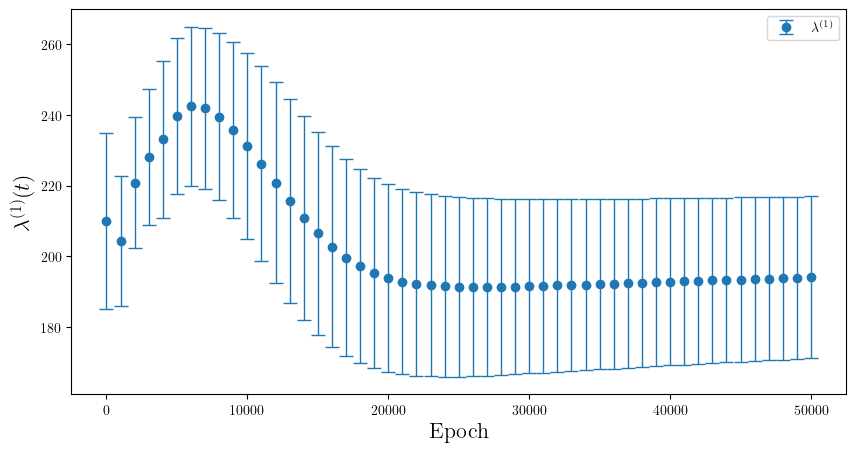

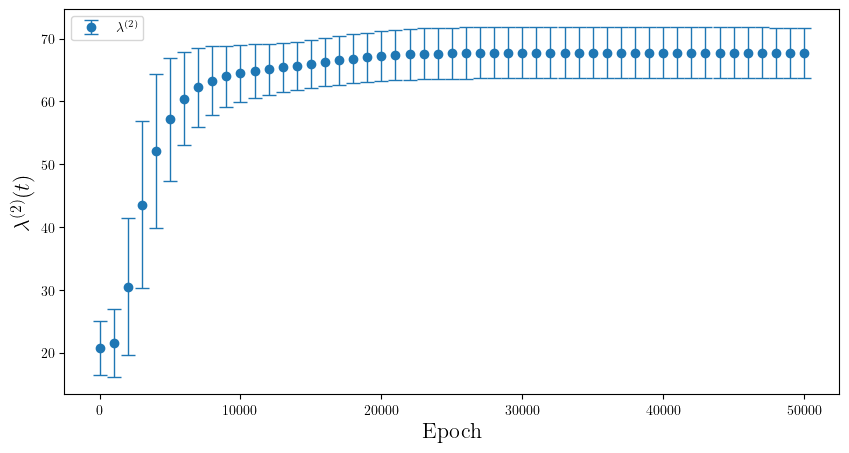

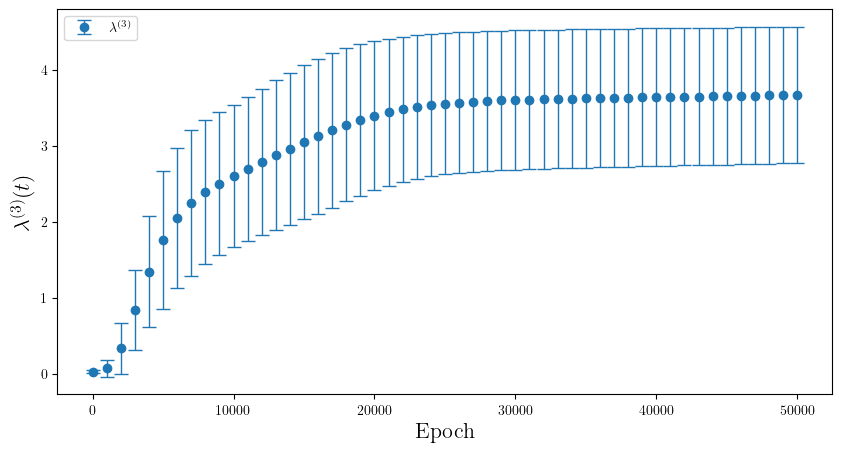

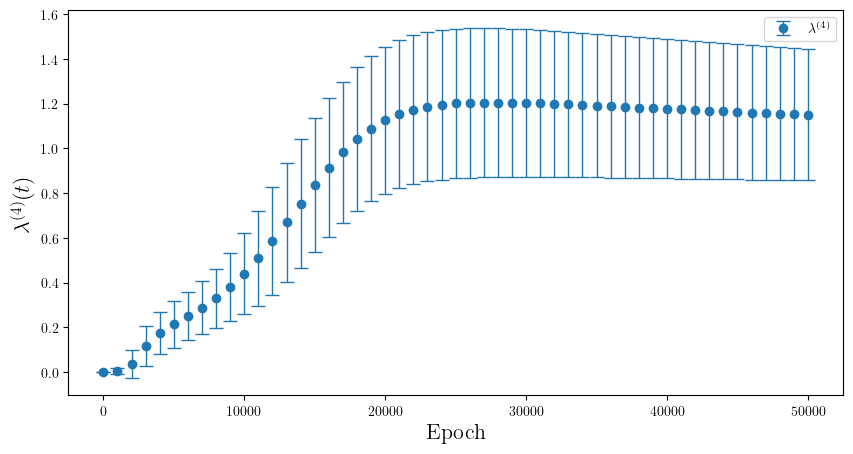

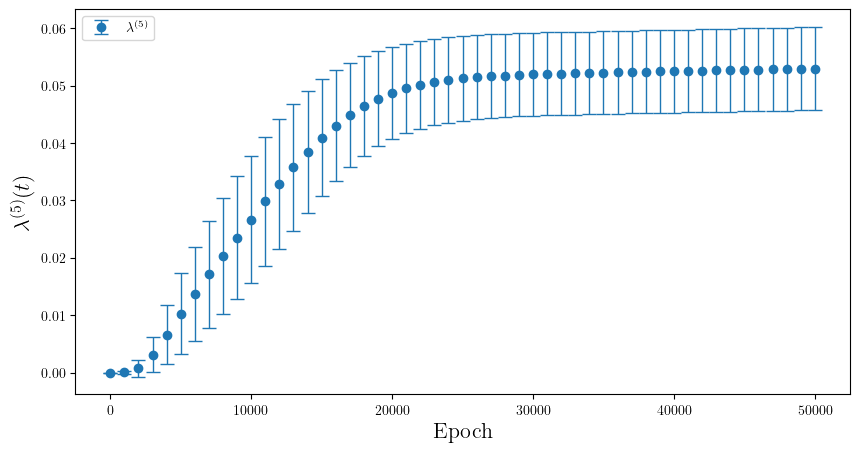

In [23]:
eigvals_time = context.eigvals_time

eigvals_mean = np.array([eigvals.get_mean(axis=0) for eigvals in eigvals_time])
eigvals_std = np.array([eigvals.get_std(axis=0) for eigvals in eigvals_time])

num_eigvals_to_plot = 5  # Number of eigenvalues to plot

for i in range(num_eigvals_to_plot):

  fig, ax = plt.subplots(1, 1, figsize=(10, 5))

  if PLOT_ERROR_BARS:
    ax.errorbar(common_epochs, eigvals_mean[:,i], yerr=eigvals_std[:,i], fmt='o', label=r'$\lambda^{(' + str(i+1) + ')}$', capsize=5, elinewidth=1, markeredgewidth=1)
  else:
    ax.plot(common_epochs, eigvals_mean[:,i], label=r'$\lambda^{(' + str(i+1) + ')}$')
    ax.fill_between(common_epochs, eigvals_mean[:,i] - eigvals_std[:,i], eigvals_mean[:,i] + eigvals_std[:,i], alpha=0.5)

  ax.set_xlabel(r'${\rm Epoch}$', fontsize=16)
  ax.set_ylabel(r'$\lambda^{(' + str(i+1) + ')}(t)$', fontsize=16)
  ax.legend()

# Plot the error in function of the epochs

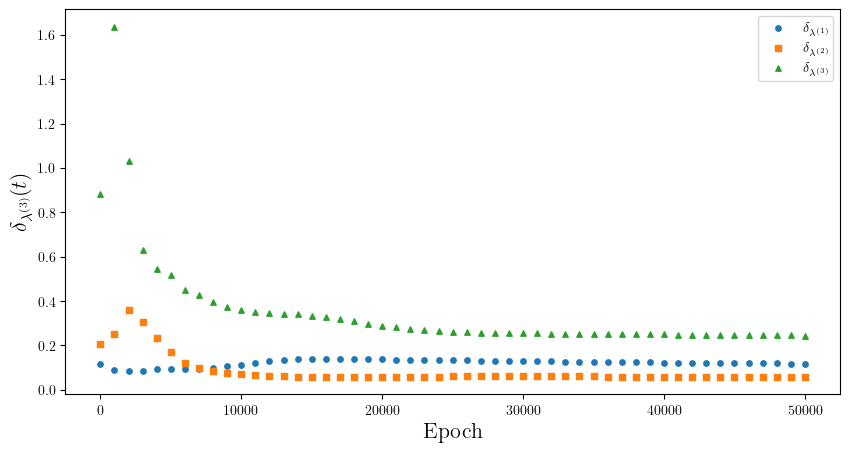

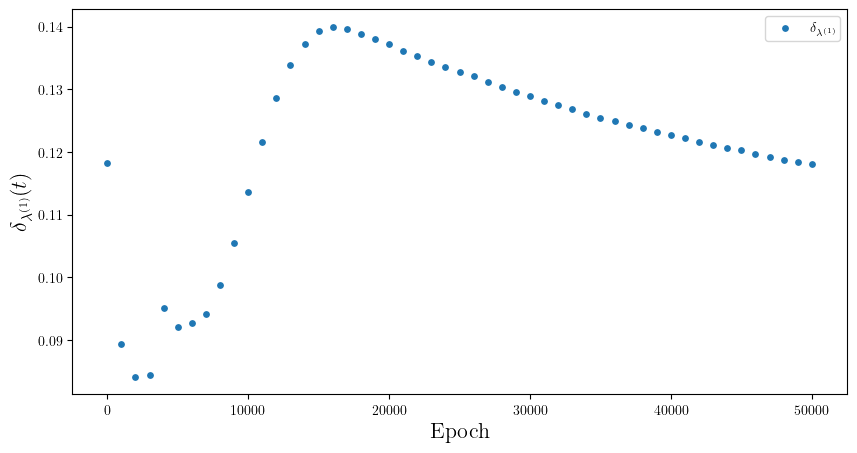

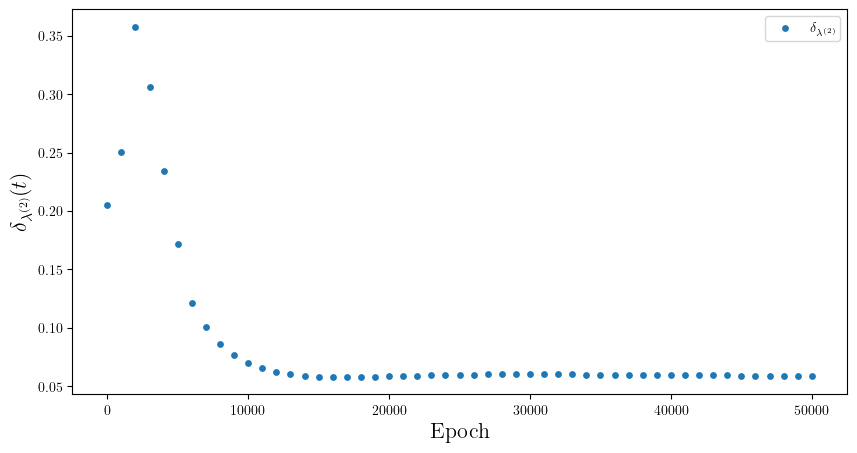

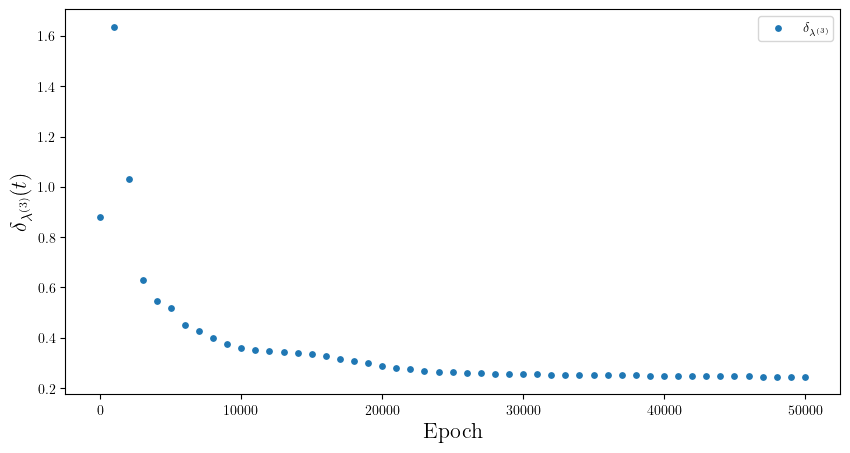

In [24]:
num_eigvals_to_plot = 3  # Number of eigenvalues to plot

point_markers = ['o', 's', '^', 'D', 'x']  # Different markers for each eigenvalue

fig_glob, ax_glob = plt.subplots(1, 1, figsize=(10, 5))

for i in range(num_eigvals_to_plot):

  fig, ax = plt.subplots(1, 1, figsize=(10, 5))

  ax.scatter(common_epochs, eigvals_std[:,i] / eigvals_mean[:,i], label=r'$\delta_{\lambda^{(' + str(i+1) + ')}}$', s=15)
  ax.set_xlabel(r'${\rm Epoch}$', fontsize=16)
  ax.set_ylabel(r'$\delta_{\lambda^{(' + str(i+1) + ')}}(t)$', fontsize=16)
  ax.legend()

  ax_glob.scatter(common_epochs, eigvals_std[:,i] / eigvals_mean[:,i], label=r'$\delta_{\lambda^{(' + str(i+1) + ')}}$', s=15, marker=point_markers[i])


ax_glob.set_xlabel(r'${\rm Epoch}$', fontsize=16)
ax_glob.set_ylabel(r'$\delta_{\lambda^{(' + str(i+1) + ')}}(t)$', fontsize=16)
ax_glob.legend()


del eigvals_std
del eigvals_mean

# Model at initialisation

In [25]:
context.get_config("metadata", "model_info")

{'architecture': [28, 20],
 'activations': 'tanh',
 'kernel_initializer': 'GlorotNormal',
 'dense_layer': 'Dense',
 'outputs': 1}

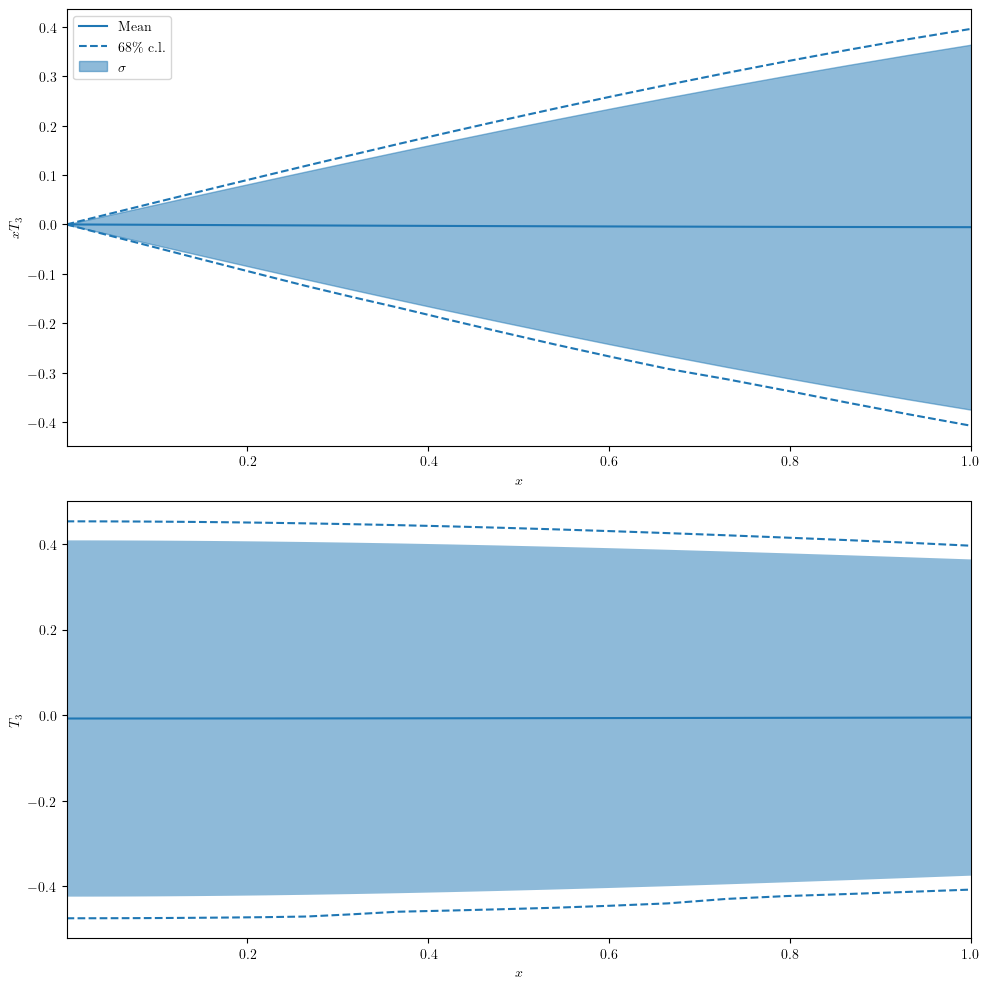

In [26]:
seed = 1423413
xT3_0 = Distribution('xT3 at initialisation')
for rep in range(nreplicas):
  model = generate_pdf_model(
          outputs=1,
          architecture=architecture,
          activations=[activation for _ in range(len(architecture))],
          kernel_initializer=kernel_initializer,
          user_ki_args=None,
          seed=seed + rep,
          scaled_input=use_scaled_input,
          preprocessing=use_preprocessing)

  xT3_0.add(model(model_input).numpy().reshape(-1))

T3_0 = xT3_0.apply_operator(b=fk_grid, operator=lambda a, b: np.true_divide(a, b), axis=0, name=f'T3 at initialisation')

(xt3_lower_bound, xt3_upper_bound) = xT3_0.get_68_percentile()
(t3_lower_bound, t3_upper_bound) = T3_0.get_68_percentile()

# Plot the distribution at initialisation
fig, axs = plt.subplots(2,1, figsize=(10, 10))
axs[0].plot(fk_grid, xT3_0.get_mean(), label=r'${\rm Mean}$', color='C0')
axs[0].plot(fk_grid, xt3_upper_bound, linestyle='--', color='C0', label=r'$\textrm{68\% c.l.}$')
axs[0].plot(fk_grid, xt3_lower_bound, linestyle='--', color='C0')
axs[0].fill_between(fk_grid, xT3_0.get_mean()  - xT3_0.get_std(), xT3_0.get_mean() + xT3_0.get_std(), alpha=0.5, color='C0', label=r'$\sigma$')
axs[0].set_ylabel(r'$xT_3$')
axs[0].set_xlabel(r'$x$')
axs[0].set_xlim([1.e-5,1])

axs[1].plot(fk_grid, T3_0.get_mean(), label=r'${\rm Mean}$', color='C0')
axs[1].fill_between(fk_grid, T3_0.get_mean()  - T3_0.get_std(), T3_0.get_mean() + T3_0.get_std(), alpha=0.5)
axs[1].plot(fk_grid, t3_upper_bound, linestyle='--', color='C0')
axs[1].plot(fk_grid, t3_lower_bound, linestyle='--', color='C0')
axs[1].set_ylabel(r'$T_3$')
axs[1].set_xlabel(r'$x$')
axs[1].set_xlim([1.e-5,1])

axs[0].legend()

fig.tight_layout()

# Check analytical solution at initialisation

In [27]:
# Load evolution
evolution = EvolutionOperatorComputer(context)

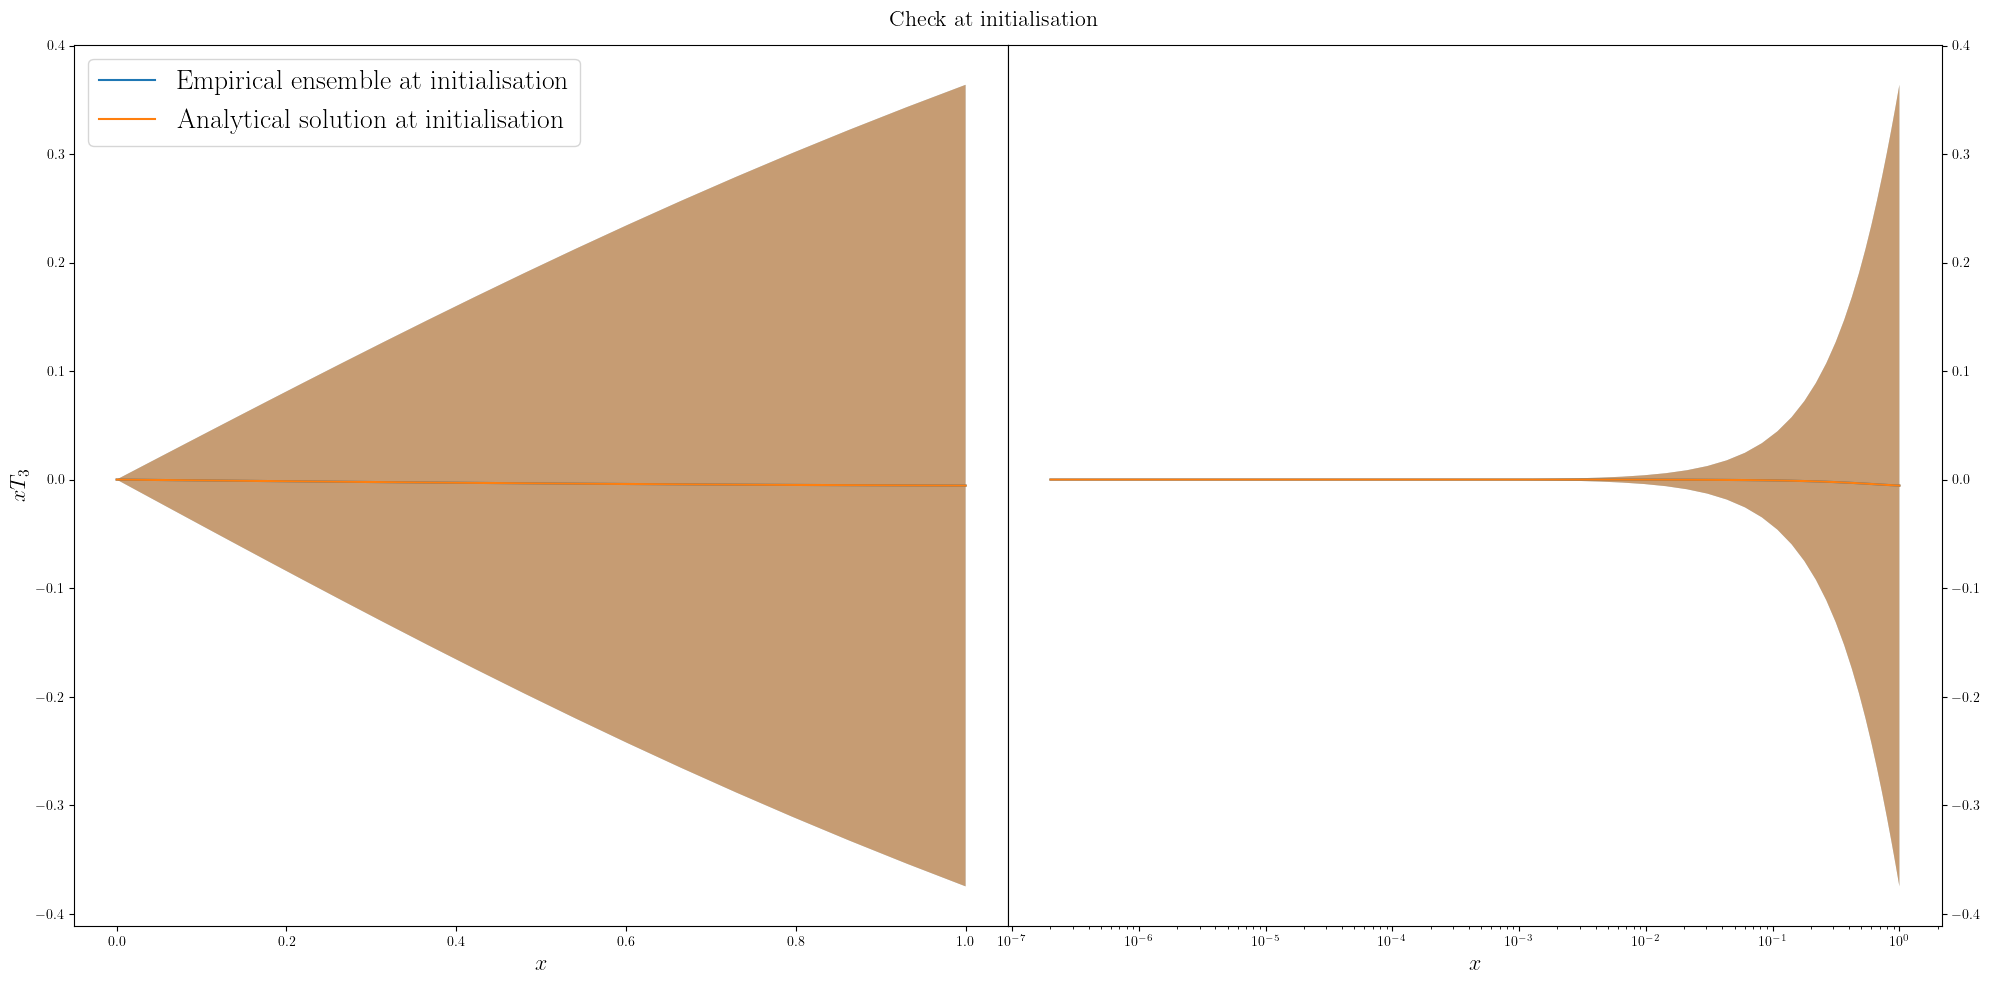

In [28]:
U, V = evolution.compute_evolution_operator(20000, 0.0)
xf_t = U @ xT3_0 + V @ data_by_replica_original

fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})
# xf linaer
axs[0].plot(fk_grid, xT3_0.get_mean(), label=r'$\textrm{Empirical ensemble at initialisation}$')
axs[0].fill_between(fk_grid, xT3_0.get_mean() - xT3_0.get_std(), xT3_0.get_mean() + xT3_0.get_std(), alpha=0.5)
axs[0].plot(fk_grid, xf_t.get_mean(), label=r'$\textrm{Analytical solution at initialisation}$')
axs[0].fill_between(fk_grid, xf_t.get_mean() - xf_t.get_std(), xf_t.get_mean() + xf_t.get_std(), alpha=0.5)

# xf log
axs[1].plot(fk_grid, xT3_0.get_mean())
axs[1].fill_between(fk_grid, xT3_0.get_mean() - xT3_0.get_std(), xT3_0.get_mean() + xT3_0.get_std(), alpha=0.5)
axs[1].plot(fk_grid, xf_t.get_mean())
axs[1].fill_between(fk_grid, xf_t.get_mean() - xf_t.get_std(), xf_t.get_mean() + xf_t.get_std(), alpha=0.5)
axs[1].set_xscale('log')
axs[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)


axs[0].set_ylabel(r'$xT_3$', fontsize=16)
axs[0].set_xlabel(r'$x$', fontsize=16)
axs[1].set_xlabel(r'$x$', fontsize=16)

axs[0].legend(fontsize=20)

fig.suptitle(r'$\textrm{Check at initialisation}$', fontsize=16)
fig.tight_layout()

# Check solution at infinity

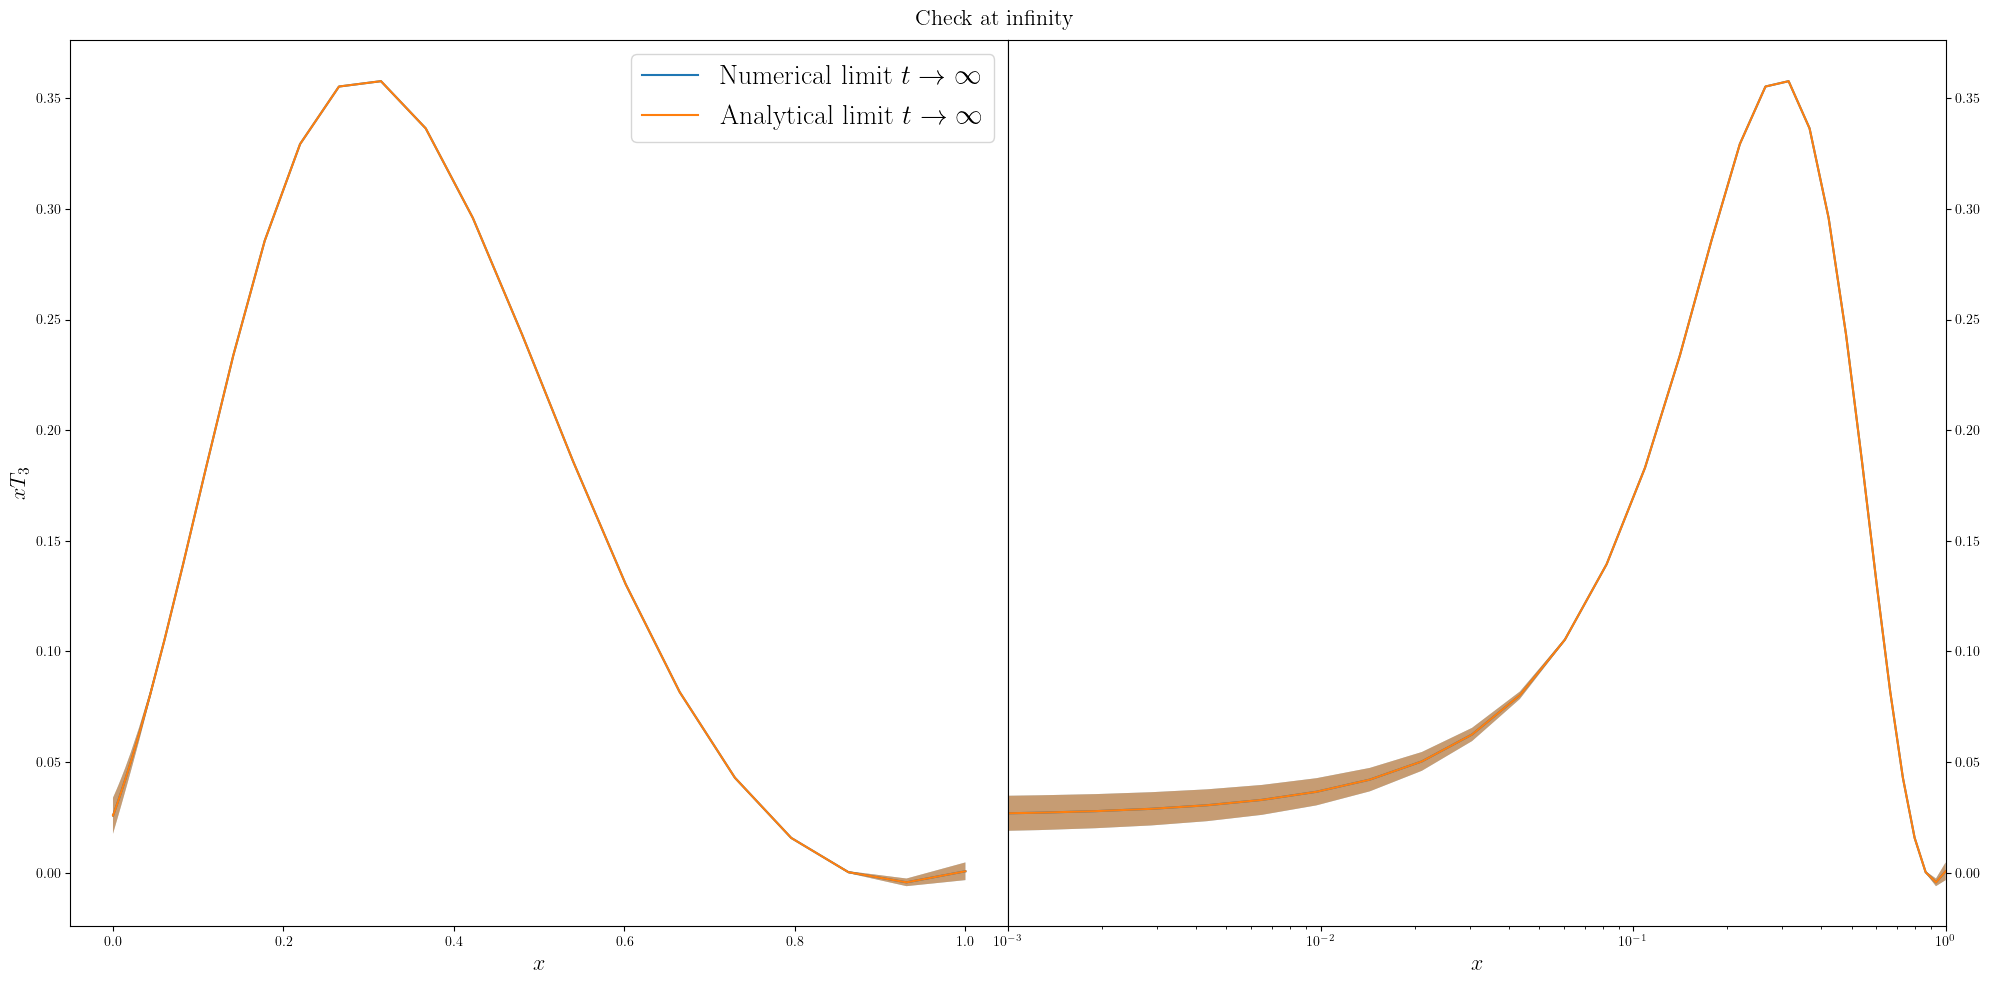

In [29]:
U, V = evolution.compute_evolution_operator(20000, 100000)
U_inf, V_inf = evolution.compute_evolution_operator_at_inf(20000)

xf_t = U @ xT3_0 + V @ data_by_replica_original
xf_inf = U_inf @ xT3_0 + V_inf @ data_by_replica_original

fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})
# xf linaer
axs[0].plot(fk_grid, xf_t.get_mean(), label=r'$\textrm{Numerical limit } t\rightarrow \infty$')
axs[0].fill_between(fk_grid, xf_t.get_mean() - xf_t.get_std(), xf_t.get_mean() + xf_t.get_std(), alpha=0.5)
axs[0].plot(fk_grid, xf_inf.get_mean(), label=r'$\textrm{Analytical limit } t\rightarrow \infty$')
axs[0].fill_between(fk_grid, xf_inf.get_mean() - xf_inf.get_std(), xf_inf.get_mean() + xf_inf.get_std(), alpha=0.5)

# xf log
axs[1].plot(fk_grid, xf_t.get_mean())
axs[1].fill_between(fk_grid, xf_t.get_mean() - xf_t.get_std(), xf_t.get_mean() + xf_t.get_std(), alpha=0.5)
axs[1].plot(fk_grid, xf_inf.get_mean())
axs[1].fill_between(fk_grid, xf_inf.get_mean() - xf_inf.get_std(), xf_inf.get_mean() + xf_inf.get_std(), alpha=0.5)
axs[1].set_xscale('log')
axs[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

axs[1].set_xlim(1.e-3, 1)
axs[0].set_ylabel(r'$xT_3$', fontsize=16)
axs[0].set_xlabel(r'$x$', fontsize=16)
axs[1].set_xlabel(r'$x$', fontsize=16)

axs[0].legend(fontsize=20)

fig.suptitle(r'$\textrm{Check at infinity }$', fontsize=16)
fig.tight_layout()

# 1) Analytical solution with random initialisation and ntk from last training epoch

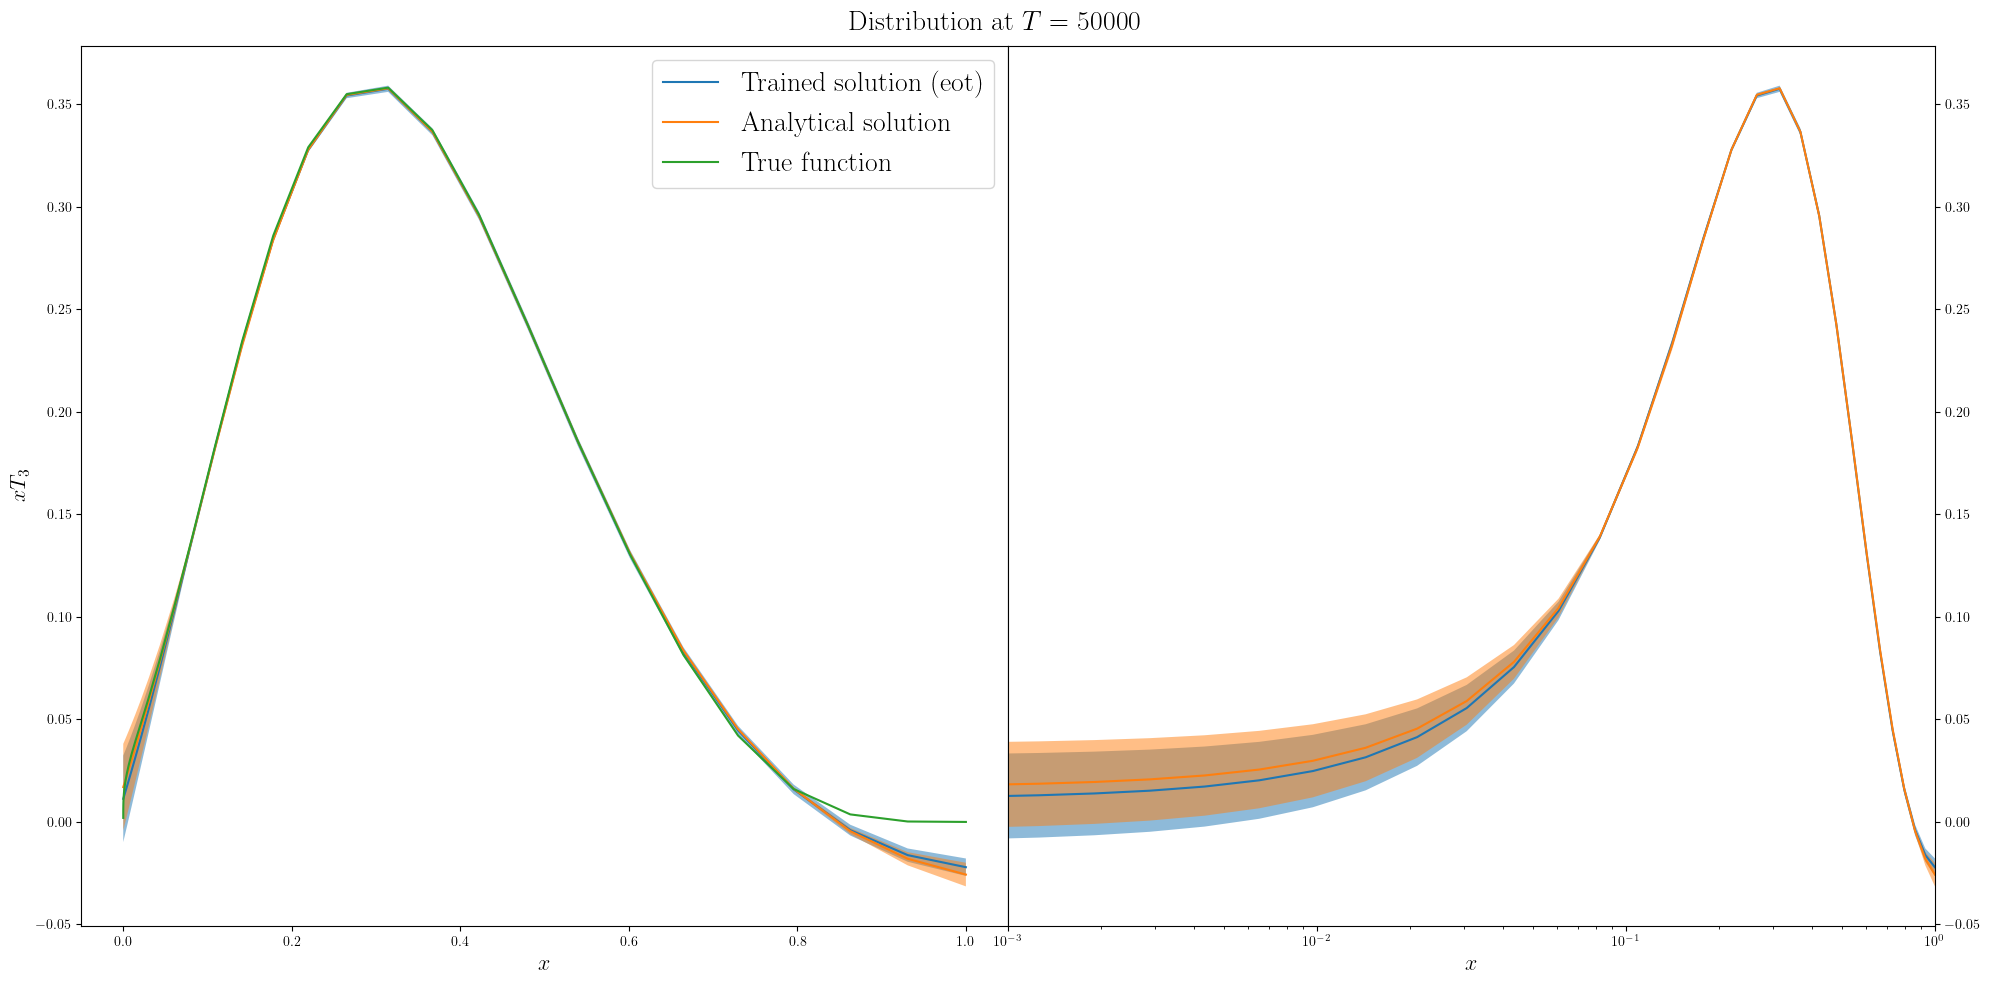

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})

evolution_epoch = 50000
t = evolution_epoch * learning_rate
U, V = evolution.compute_evolution_operator(20000, t)
xT3_t = U @ xT3_0 + V @ data_by_replica_original

# xf linaer
axs[0].plot(fk_grid, xT3_training.get_mean(), label=r'$\textrm{Trained solution (eot)}$')
axs[0].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), alpha=0.5)
axs[0].plot(fk_grid, xT3_t.get_mean(), label=r'$\textrm{Analytical solution}$')
axs[0].fill_between(fk_grid, xT3_t.get_mean() - xT3_t.get_std(), xT3_t.get_mean() + xT3_t.get_std(), alpha=0.5)
axs[0].plot(fk_grid, f_bcdms, label=r'$\textrm{True function}$')

# xf log
axs[1].plot(fk_grid, xT3_training.get_mean())
axs[1].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), alpha=0.5)
axs[1].plot(fk_grid, xT3_t.get_mean())
axs[1].fill_between(fk_grid, xT3_t.get_mean() - xT3_t.get_std(), xT3_t.get_mean() + xT3_t.get_std(), alpha=0.5)
axs[1].set_xscale('log')
axs[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)
axs[1].set_xlim([1.e-3, 1])


axs[0].set_ylabel(r'$xT_3$', fontsize=16)
axs[0].set_xlabel(r'$x$', fontsize=16)
axs[1].set_xlabel(r'$x$', fontsize=16)
axs[0].legend(fontsize=20)

fig.suptitle(rf"$\textrm{{Distribution at }} T = {{{evolution_epoch}}}$", fontsize=20)
fig.tight_layout()

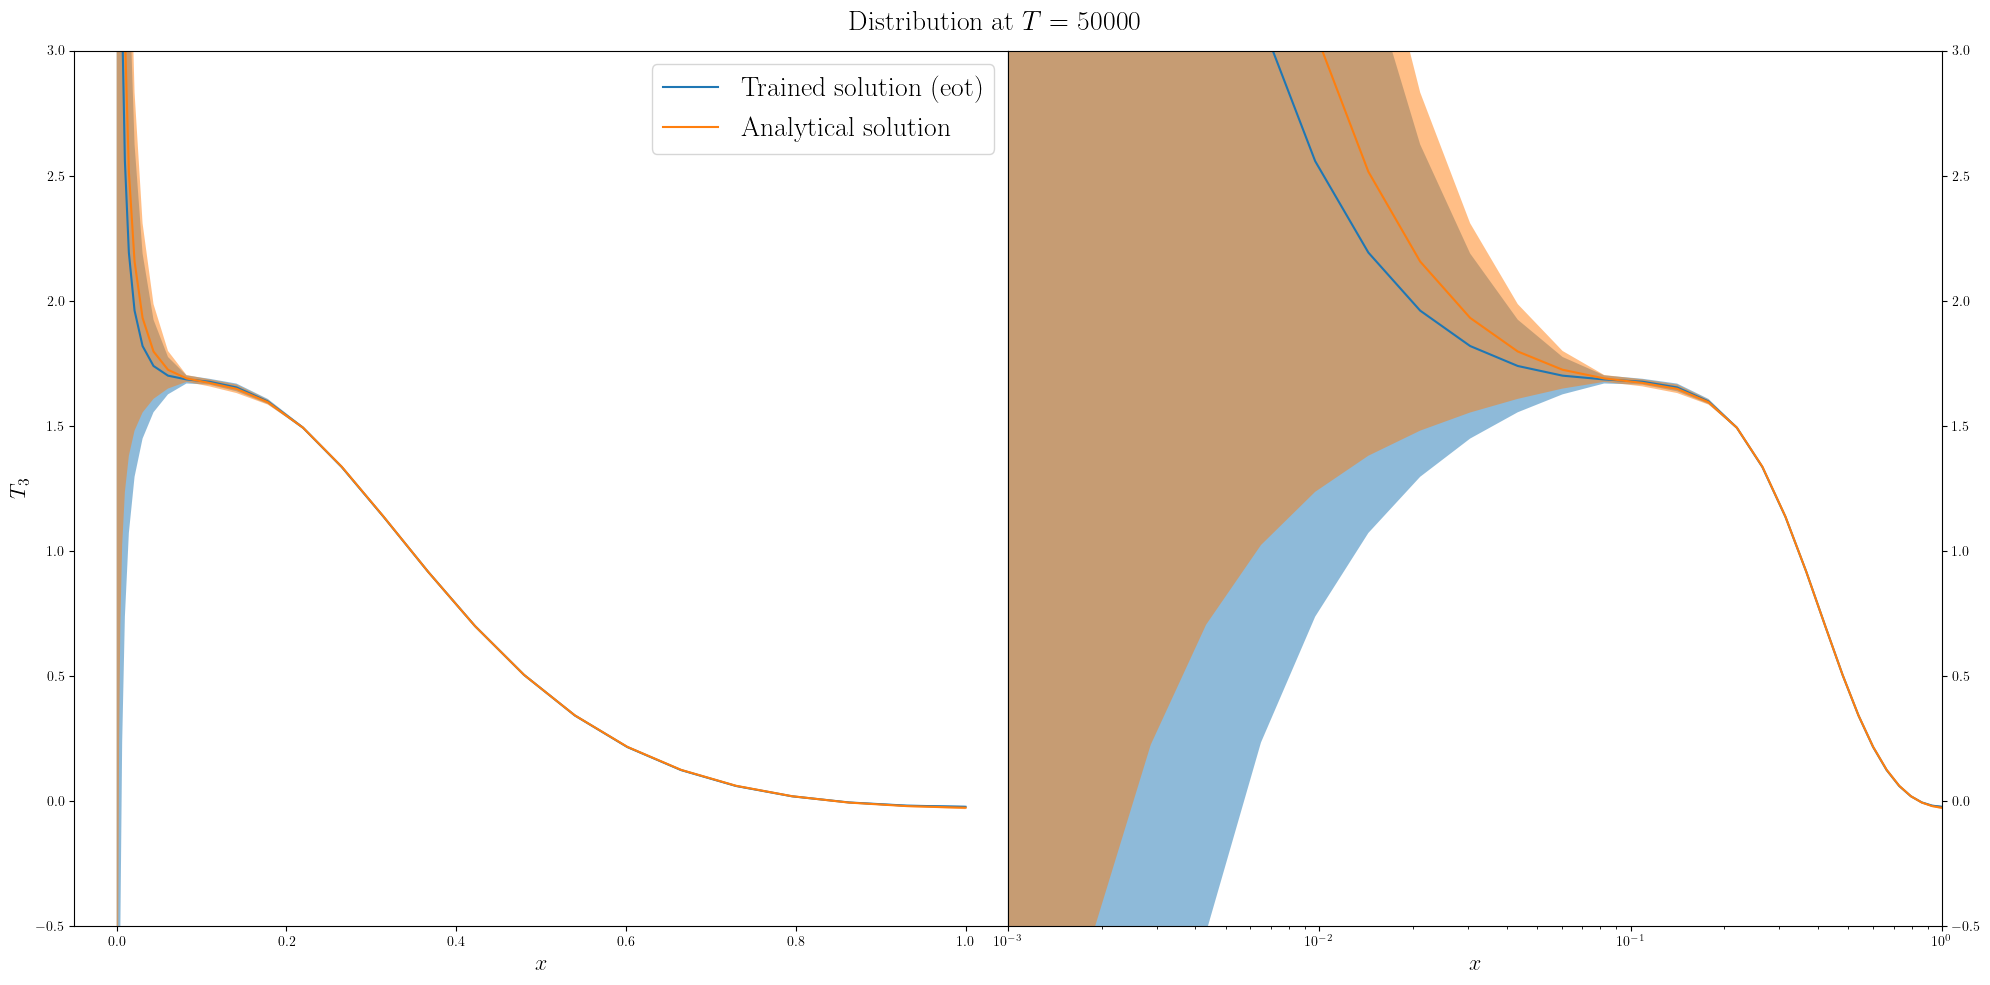

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})
T3_t = xT3_t.apply_operator(b=fk_grid, operator=lambda a, b: np.true_divide(a, b), axis=0, name=f'T3 at t={t}')

# xf linaer
axs[0].plot(fk_grid, T3_training.get_mean(), label=r'$\textrm{Trained solution (eot)}$')
axs[0].fill_between(fk_grid, T3_training.get_mean() - T3_training.get_std(), T3_training.get_mean() + T3_training.get_std(), alpha=0.5)
axs[0].plot(fk_grid, T3_t.get_mean(), label=r'$\textrm{Analytical solution}$')
axs[0].fill_between(fk_grid, T3_t.get_mean() - T3_t.get_std(), T3_t.get_mean() + T3_t.get_std(), alpha=0.5)

# xf log
axs[1].plot(fk_grid, T3_training.get_mean())
axs[1].fill_between(fk_grid, T3_training.get_mean() - T3_training.get_std(), T3_training.get_mean() + T3_training.get_std(), alpha=0.5)
axs[1].plot(fk_grid, T3_t.get_mean())
axs[1].fill_between(fk_grid, T3_t.get_mean() - T3_t.get_std(), T3_t.get_mean() + T3_t.get_std(), alpha=0.5)
axs[1].set_xscale('log')
axs[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)
axs[1].set_xlim([1.e-3, 1])

axs[0].set_ylabel(r'$T_3$', fontsize=16)
axs[0].set_xlabel(r'$x$', fontsize=16)
axs[1].set_xlabel(r'$x$', fontsize=16)

axs[0].legend(fontsize=20)
axs[0].set_ylim(-0.5,3)
axs[1].set_ylim(-0.5,3)

fig.suptitle(rf"$\textrm{{Distribution at }} T = {{{evolution_epoch}}}$", fontsize=20)
fig.tight_layout()

# 2) Analytical solution with initial condition at $t = t_{\rm ref}$

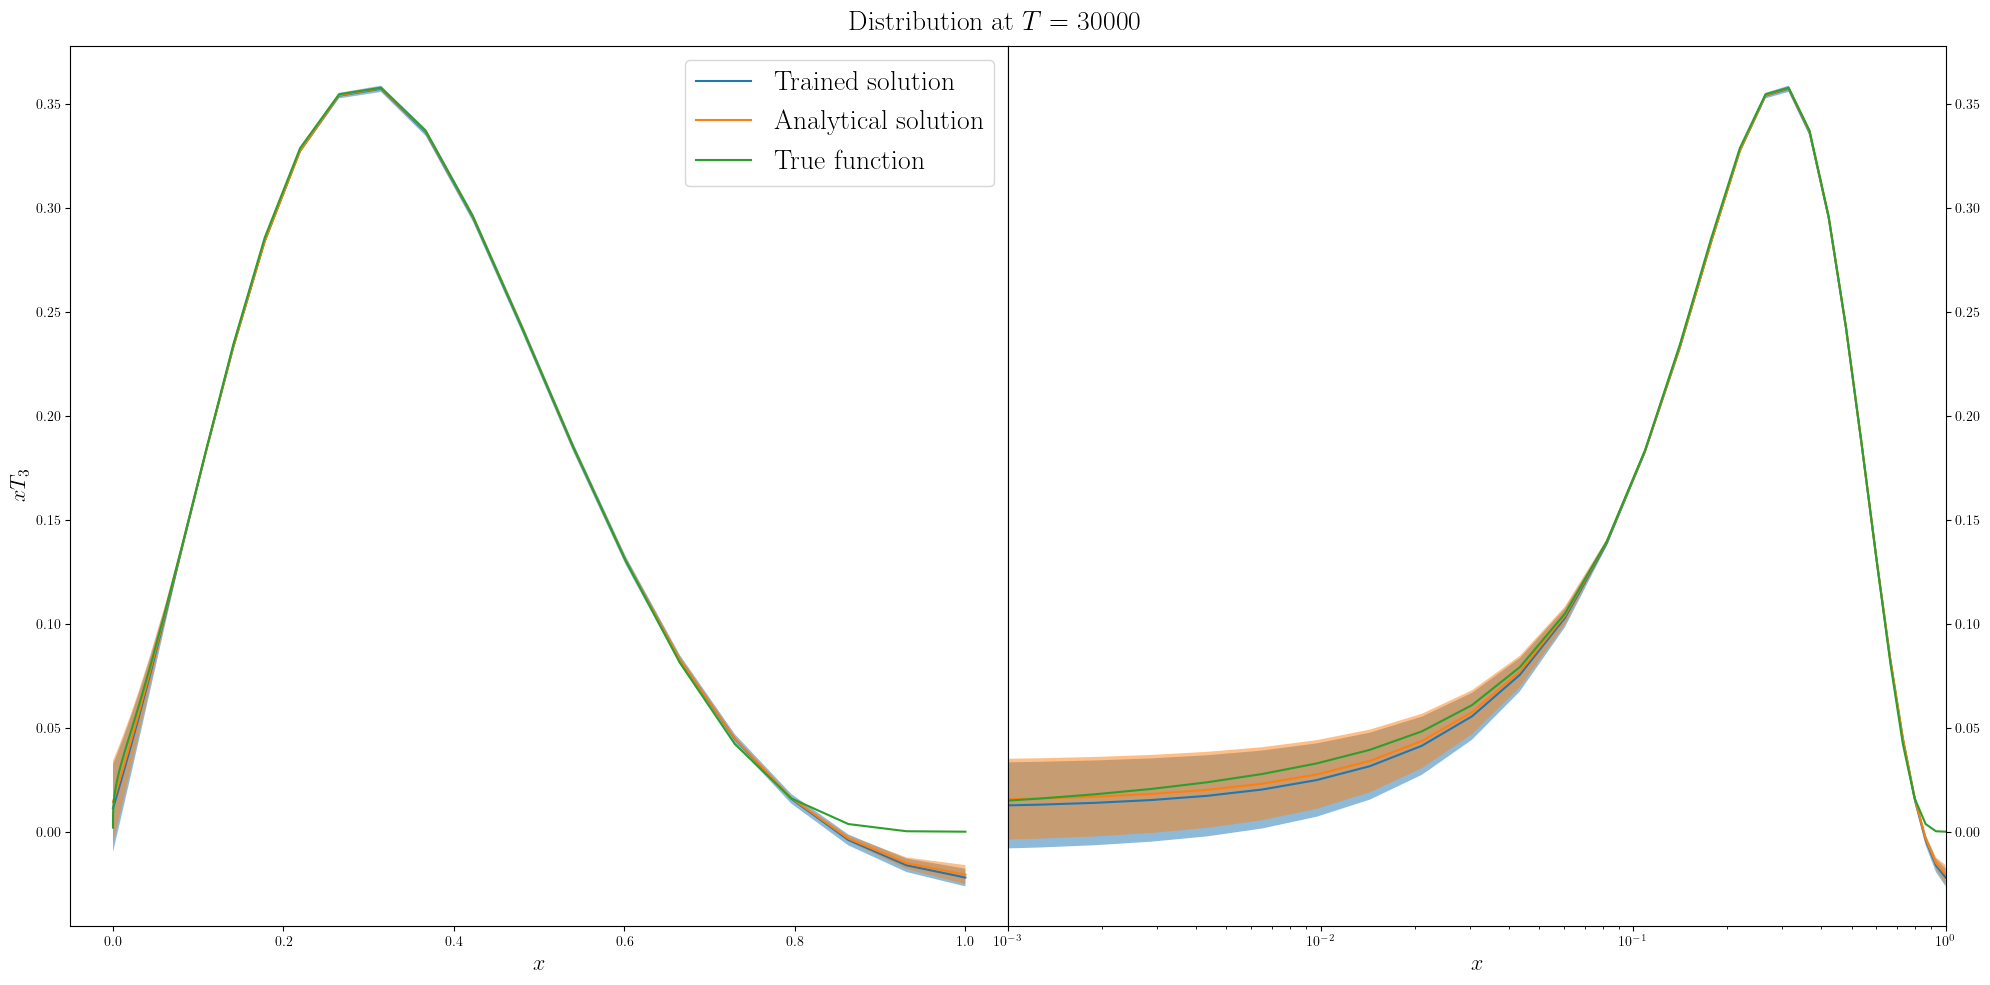

In [32]:
ref_epoch = 20000
xT3_ref = Distribution('xT3 at reference epoch')
last_epoch = common_epochs[-1]

# Get trained model at the reference epoch
for replica_path in replicas_folders:
    model, _ = load_trained_model(replica_path, epoch=ref_epoch)
    preds = model(model_input).numpy().squeeze()
    xT3_ref.add(preds)

elapsed_epochs = last_epoch - ref_epoch
t = elapsed_epochs * learning_rate
U, V = evolution.compute_evolution_operator(ref_epoch, t)
xT3_t = U @ xT3_ref + V @ data_by_replica_original

fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})

# xf linaer
axs[0].plot(fk_grid, xT3_training.get_mean(), label=r'$\textrm{Trained solution}$')
axs[0].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), alpha=0.5)
axs[0].plot(fk_grid, xT3_t.get_mean(), label=r'$\textrm{Analytical solution}$')
axs[0].fill_between(fk_grid, xT3_t.get_mean() - xT3_t.get_std(), xT3_t.get_mean() + xT3_t.get_std(), alpha=0.5)
axs[0].plot(fk_grid, f_bcdms, label=r'$\textrm{True function}$')

# xf log
axs[1].plot(fk_grid, xT3_training.get_mean())
axs[1].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), alpha=0.5)
axs[1].plot(fk_grid, xT3_t.get_mean())
axs[1].fill_between(fk_grid, xT3_t.get_mean() - xT3_t.get_std(), xT3_t.get_mean() + xT3_t.get_std(), alpha=0.5)
axs[1].plot(fk_grid, f_bcdms, label=r'$\textrm{True function}$')

axs[1].set_xscale('log')
axs[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)
axs[1].set_xlim([1.e-3,1])


axs[0].set_ylabel(r'$xT_3$', fontsize=16)
axs[0].set_xlabel(r'$x$', fontsize=16)
axs[1].set_xlabel(r'$x$', fontsize=16)

axs[0].legend(fontsize=20)

fig.suptitle(rf"$\textrm{{Distribution at }} T = {{{elapsed_epochs}}}$", fontsize=20)
fig.tight_layout()

# 3) Contribution of $U$ and $V$ separately

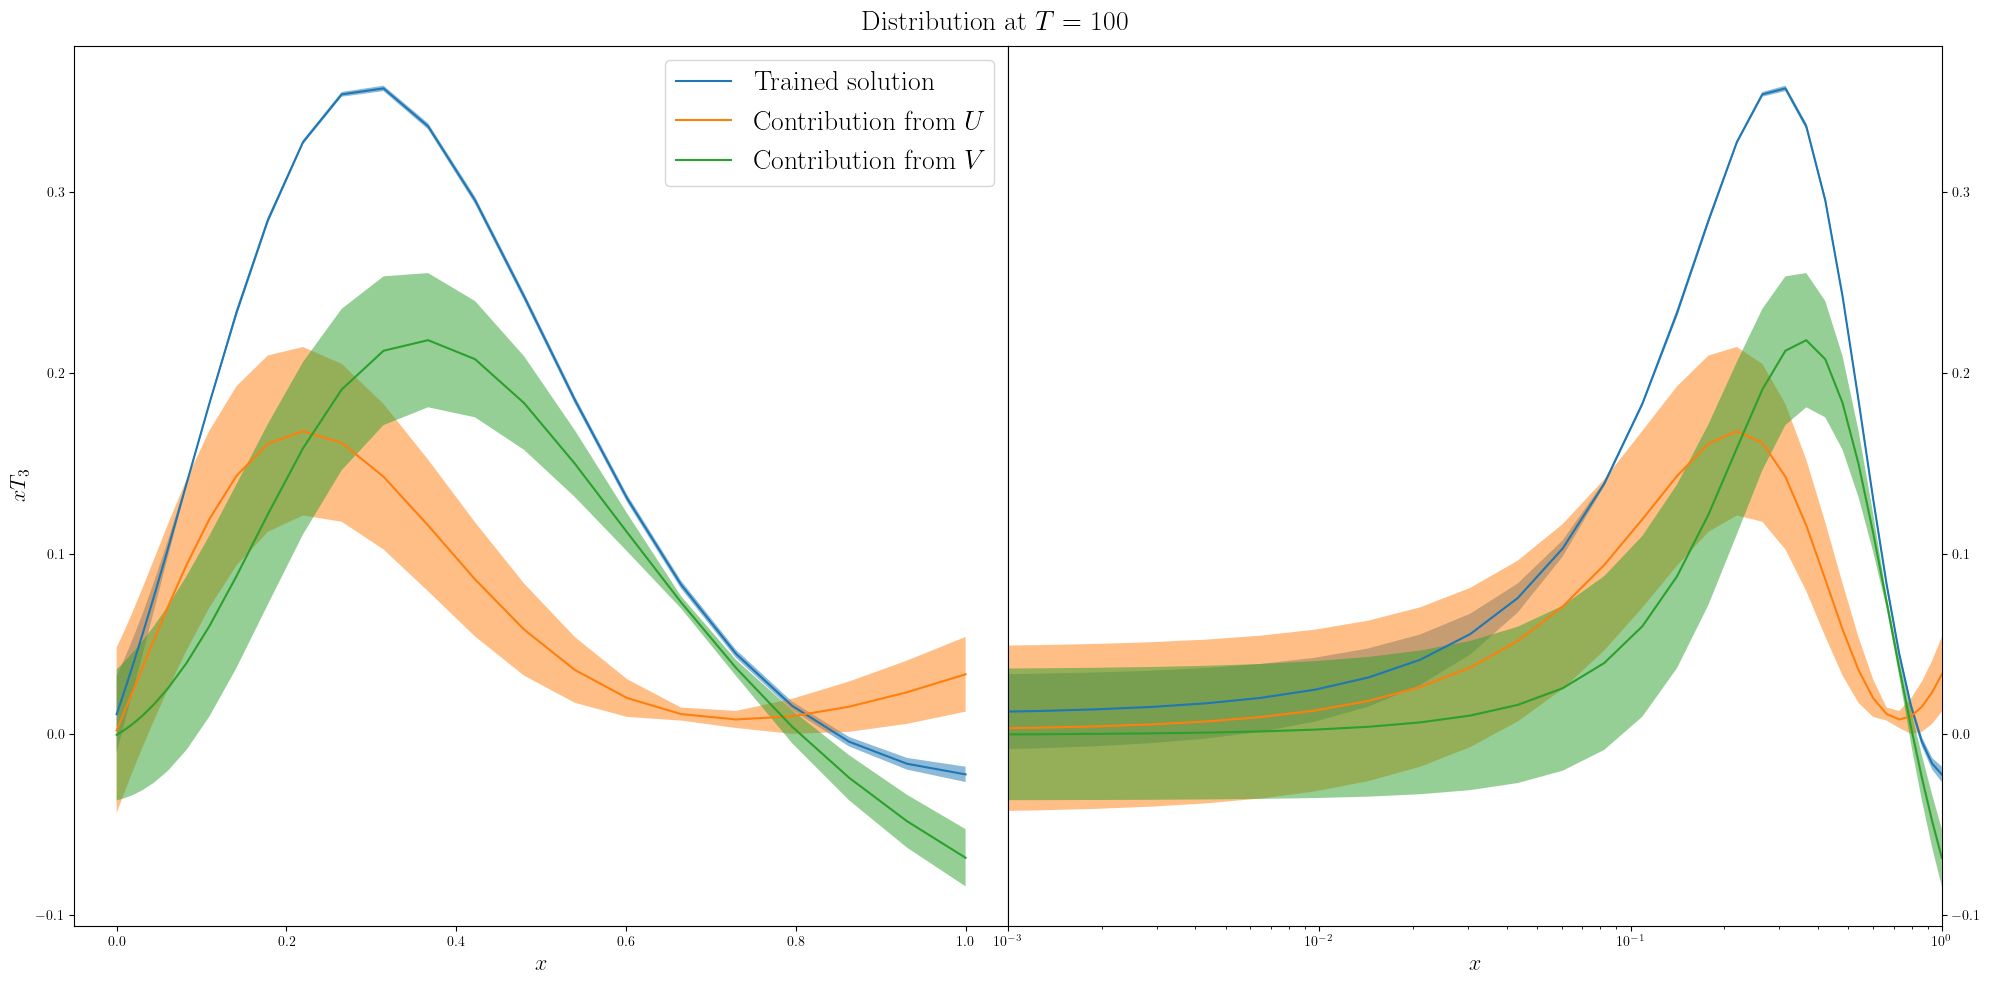

In [33]:
ref_epoch = 20000
xT3_ref = Distribution('xT3 at reference epoch')
last_epoch = common_epochs[-1]

# Get trained model at the reference epoch
for replica_path in replicas_folders:
    model, _ = load_trained_model(replica_path, epoch=ref_epoch)
    preds = model(model_input).numpy().reshape(-1)
    xT3_ref.add(preds)

t = 0.001#(common_epochs[-1] - ref_epoch) * learning_rate
U, V = evolution.compute_evolution_operator(ref_epoch, t)
xT3_t_u = U @ xT3_ref
xT3_t_v = V @ data_by_replica_original

fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})

# xf linaer
axs[0].plot(fk_grid, xT3_training.get_mean(), label=r'$\textrm{Trained solution}$')
axs[0].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), alpha=0.5)

axs[0].plot(fk_grid, xT3_t_u.get_mean(), label=r'$\textrm{Contribution from } U$')
axs[0].fill_between(fk_grid, xT3_t_u.get_mean() - xT3_t_u.get_std(), xT3_t_u.get_mean() + xT3_t_u.get_std(), alpha=0.5)

axs[0].plot(fk_grid, xT3_t_v.get_mean(), label=r'$\textrm{Contribution from } V$')
axs[0].fill_between(fk_grid, xT3_t_v.get_mean() - xT3_t_v.get_std(), xT3_t_v.get_mean() + xT3_t_v.get_std(), alpha=0.5)

# xf log
axs[1].plot(fk_grid, xT3_training.get_mean())
axs[1].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), alpha=0.5)

axs[1].plot(fk_grid, xT3_t_u.get_mean())
axs[1].fill_between(fk_grid, xT3_t_u.get_mean() - xT3_t_u.get_std(), xT3_t_u.get_mean() + xT3_t_u.get_std(), alpha=0.5)

axs[1].plot(fk_grid, xT3_t_v.get_mean())
axs[1].fill_between(fk_grid, xT3_t_v.get_mean() - xT3_t_v.get_std(), xT3_t_v.get_mean() + xT3_t_v.get_std(), alpha=0.5)

axs[1].set_xscale('log')
axs[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)
axs[1].set_xlim([1.e-3,1])


axs[0].set_ylabel(r'$xT_3$', fontsize=16)
axs[0].set_xlabel(r'$x$', fontsize=16)
axs[1].set_xlabel(r'$x$', fontsize=16)

axs[0].legend(fontsize=20)

fig.suptitle(rf"$\textrm{{Distribution at }} T = {{{int(t / learning_rate)}}}$", fontsize=20)
fig.tight_layout()